### Notebook 4 Modeling part 2

# Table of Contents 

### [Modeling](#part1)
   - [Linear Regression](#p1q1)<br>
   - [K Nearest Neighbour Regression](#p1q2)<br>
   - [Gradient Boosting Regressor ](#p1q3)<br>
   - [XG Boosting Regressor ](#p1q4)<br>
   
### [Model Evaluation](#part2)
   
   -[Gradient Boosting](#p2q1)<br>
 
#### Introduction  
This is the final notebook for modelling. We have initialized our models previously and are now working to tune the models to best predict our housing price. As our business goal is to be able to help make better business decisions when it comes to predicting a homes sales price this can be used for both the buying side knowing what the home is worth, as well on the sell side on what amount should the price be listed to target a sale. 

This final notebook will have the following flow. We will begin by tuning our data one last time, dropping any columns that are not needed. We will be looking at the following models that we have previously tested with minor success. 
- Linear Regression
- K Nearest Neighbour Regression
- Gradient Boosting 
- XG Boosting

So far we have observed that although our train set Gradient boosting has the highest R sqared value, we see that this is significantly overfit, while XG boosting although a lower train R-Squared has a closed fit to its test set.

We do also start to look into list date as a factor. Instead of only randomly test our homes that have been listed over the past 4 years, we look at a more realistic approach which is to organize home in chronological order, such that our test set will be considered data in the future that our model is not aware of. We hope to train our model using the first 80% of homes listed this will prove to be a more realistic approach for a our model though may have lower ability to predict as well or in other words more variance. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
import pickle



We start by loading our cleaned and preprocessed data. The data has been cleaned by removing any duplicates as well as null values. We also applied One Hot Encoding to two columns, Postal code and city. The postal code as been focused on with the first three characters of the postal code which reflects the distribution center which has a higher granularity than a city but less than a block or two. We begin with 533 columns and 139590 rows. 

In [2]:
df = pd.read_csv('/Users/davidongtenco/Desktop/Capstone-Predicting home prices /data/data_ohe.csv')
df['List Date'] = pd.to_datetime(df['List Date'])




In [3]:
#Sanity check to make sure only sold homes are listed. 
df['Status'].value_counts()

1    131495
Name: Status, dtype: int64

In [4]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131495 entries, 0 to 131494
Columns: 502 entries, Unnamed: 0.1 to ('Yarrow',)
dtypes: datetime64[ns](1), float64(1), int64(483), object(17)
memory usage: 503.6+ MB


In [5]:
df.head()


,Unnamed: 0.1,Unnamed: 0,Picture Count,Listing Pictures,ML #,Status,Address,City,Postal Code,S/A,...,"('Williams Lake',)","('Williams Lake - City',)","('Williams Lake - Rural East',)","('Williams Lake - Rural North',)","('Williams Lake - Rural South',)","('Williams Lake - Rural West',)","('Willow River',)","('Wilson Creek',)","('Yale',)","('Yarrow',)"
0,0,4,1,//cdnparap130.paragonrels.com/ParagonImages/Pr...,R2329141,1,6107 IMPERIAL STREET,Burnaby,V5T,VBSUD,...,0,0,0,0,0,0,0,0,0,0
1,1,5,1,//cdnparap130.paragonrels.com/ParagonImages/Pr...,R2329328,1,10351 SCOTSDALE AVENUE,Richmond,V7E,VRI41,...,0,0,0,0,0,0,0,0,0,0
2,2,10,12,//cdnparap130.paragonrels.com/ParagonImages/Pr...,R2329293,1,1215 WAVERLEY AVENUE,Vancouver,V5W,VVEKN,...,0,0,0,0,0,0,0,0,0,0
3,3,15,16,//cdnparap130.paragonrels.com/ParagonImages/Pr...,R2328821,1,10127 MARY DRIVE,Surrey,V3V,F25,...,0,0,0,0,0,0,0,0,0,0
4,4,17,16,//cdnparap130.paragonrels.com/ParagonImages/Pr...,R2328916,1,15449 95 AVENUE,Surrey,V3R,F34,...,0,0,0,0,0,0,0,0,0,0


We see an error with the data frame above that two columns ahve been created namely unamed 0.1 and Unamed 0. These two need to be dropped together with a few columsn that have significant null and missing values. These features may be feature engineered in the future. However for the purpose of this capstone will be dropped. 

In [6]:
df1=df.drop(['Listing Pictures','Unnamed: 0','ML #','City','Postal Code','S/A',\
              'Address','Depth','TypeDwel','Style of Home','Fixtures Removed Y/N',\
              'Fixtures Remvd','Last Trans Date','Distance to Pub/Rapid Tr',\
              'Dist to School/School Bus','Sold Price','Sold Date','Type',\
              'List_Price_num','Parking Places - Total','Status'],axis = 1)

df1 = df1.drop([col for col in df1.columns if 'Unnamed' in col],axis=1)
          
          
        
          

In [7]:
df_date=df1


We will create two sets of data frames, one which goes through the train, validation and test by random order. And another set that is organized by list date. To set by list date we need to set our index to be the column 'List Date'. Further more we use the function sort_index to list in ascending order. Or from oldest list to most recent list.

##### Train+Validation+Test split with respect to time <a class ='anchor' id = 'part1' ></a> 

In [8]:

df_date = df_date.set_index('List Date')
df_date=df_date.sort_index()
df_test=df1

In [9]:
X_date = df_date.drop(['Price_num'], axis=1)
y_date = df_date['Price_num'] 
threshold = int(X_date.shape[0]*0.8)
print(threshold)
X_remainder_date = X_date.iloc[0:threshold,:]
X_test_date = X_date.iloc[threshold:,:]

# Sanity check/do the sum of number of rows match unsplit
print(X_remainder_date.shape[0]+ X_test_date.shape[0],X_date.shape[0])


y_remainder_date = y_date.iloc[0:threshold]
y_test_date = y_date.iloc[threshold:]



105196
131495 131495


In [10]:
X_test_date.iloc[[4000]]

,Picture Count,DOM,Tot BR,Tot Baths,TotFlArea,Lot Sz (Sq.Ft.),Frontage - Feet,#Kitchens,Prop_taxes,List_date_month,...,"('Williams Lake',)","('Williams Lake - City',)","('Williams Lake - Rural East',)","('Williams Lake - Rural North',)","('Williams Lake - Rural South',)","('Williams Lake - Rural West',)","('Willow River',)","('Wilson Creek',)","('Yale',)","('Yarrow',)"
List Date,,,,,,,,,,,,,,,,,,,,,
2021-08-30,39,30,5,4,4390,1140900,52,1,748921,8,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_test=df_test.set_index('List Date').sort_index()
df_test=df_test.iloc[threshold:]



##### Train+Validation+Test split without respect to time
For the train, validation, and test split that does not include time. We drop the list date as we will not be able to run a regression with this in. 

In [12]:
df1=df1.drop(['List Date'], axis = 1)

We primarily have two data frames from the same data, one is organized and has its index based on the date, while the second is not organized at all. Based on these two data frames we will create the train test split as well as validation split in order to reduce the overfitting that we saw in our first notebook. 

In [13]:
from sklearn.model_selection import train_test_split

X = df1.drop(['Price_num'], axis=1)
y = df1['Price_num'] 
    
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X, y, test_size = 0.20,
                     random_state=1)

## Linear Regression <a class ='anchor' id = 'p1q1' ></a> 

The first model we change into is the linear regression. We will test the model on two types of data. The data frame that is organized by date and not by date. A major difference from the linear regression in the first notebook is that we will use the linear regression from Sk learn instead of the os.linear regression. 

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [13]:
reg = LinearRegression()
reg_fit= reg.fit(X_remainder, y_remainder)
print(f"R^2 score on training set: {reg_fit.score(X_remainder, y_remainder)}")
print(f"R^2 score on test set: {reg_fit.score(X_test, y_test)}")

R^2 score on training set: 0.7583259990768156
R^2 score on test set: 0.7447727712363076


On the most basic model, we run a linear regression as our baseline. We achieved a 0.708 R-squared value for our train and a 0.606 R-squared for our test set. This is a fairly good baseline where our model although not performing at its best shows that we are able to slightly predict our home sales price. 

Next we look at how our model performs with K fold cross validation. We use 5 fold to be able to find the average train score. We were able to achieve 0.700 with varying combinations of train and validation sets. For clarification a train+validation+test split makes up all of our data. We split the data into three portions to be able to test and improve our model to perform better as well as reduce overfitting. 

In [14]:
scores = cross_val_score(reg, X_remainder, y_remainder, cv = 5)


In [15]:
for i in range(len(scores)) :
    print(f"Fold {i+1}: {scores[i]}")
    
print(f"Average Score:{np.mean(scores)}")    

Fold 1: 0.7788355578469341
Fold 2: 0.6186170230892394
Fold 3: 0.7795858650879984
Fold 4: 0.7443867846573322
Fold 5: 0.6670229312431478
Average Score:0.7176896323849304


You can also use K-fold cross validation in order to improve our parameters. You will find an example below were we use varying different c values in a for loop to find the highest R-squared value. 

In [16]:
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    reg = LinearRegression(n_jobs=c)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(reg, X_remainder, y_remainder, cv = 5))
    
    cross_validation_scores.append(cv_score)

With the information inputted we plot this below. Although we changed the c value, this does not have a significant impact on our R-squared value. This means that we will not need to change anything for our linear regression. 

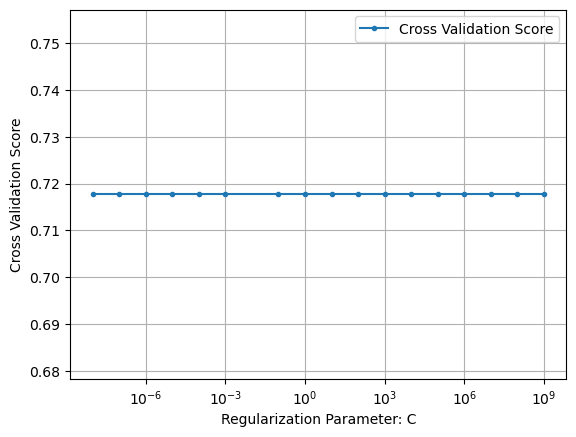

In [17]:
plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

In [18]:
reg_date = LinearRegression()
reg_fit_date= reg_date.fit(X_remainder_date, y_remainder_date)
print(f"R^2 score on training set: {reg_fit_date.score(X_remainder_date, y_remainder_date)}")
print(f"R^2 score on test set: {reg_fit_date.score(X_test_date, y_test_date)}")

R^2 score on training set: 0.7601028167376984
R^2 score on test set: 0.6918978346039175


## K Nearest Neighbour Regressor (KNN) <a class ='anchor' id = 'p1q2' ></a> 

The next model we will attempt is the K Nearest Neighbour Regressor. As a simple explanation, the KNN regression model uses clusters or data points that have very similar attibutes and groups them. Through this we are able to predict that if something nearby occurs that a similar data point may have the same effect. 

As we have seen in the linear regression we will apply K fold cross validation to find the very accuracy score 

AttributeError: module 'matplotlib.pyplot' has no attribute 'tittle'

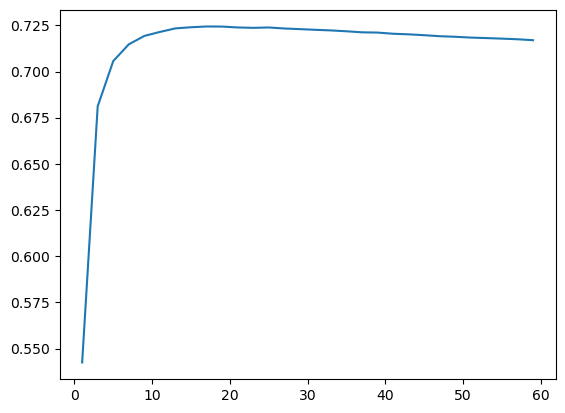

In [19]:
# Define our list of k values to try out
k_values = list(range(1, 61, 2))

# Create a list to hold our cross-validation scores
cv_scores = []


# OPTIONAL (if you want a scatterplot of individual fold validation scores)
# NOT TYPICALLY DONE
x_points = []
y_points = []



for k in k_values:

    
    # Instantiate a knn classifier
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Calculate the 4 validation scores via cross-val & append average to list
    scores = cross_val_score(knn, X_remainder, y_remainder, cv=4)
    
    cv_scores.append(np.mean(scores))
    

    # OPTIONAL: Keep track of x & y coordinates of every fold's validation score
    x_points.extend([k]*4)
    y_points.extend(scores)
    

plt.figure()
plt.plot(k_values, cv_scores)
plt.title('Accuracy and N_neighbours')
#plt.scatter(x_points, y_points, alpha=0.5) # OPTIONAL
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.show()

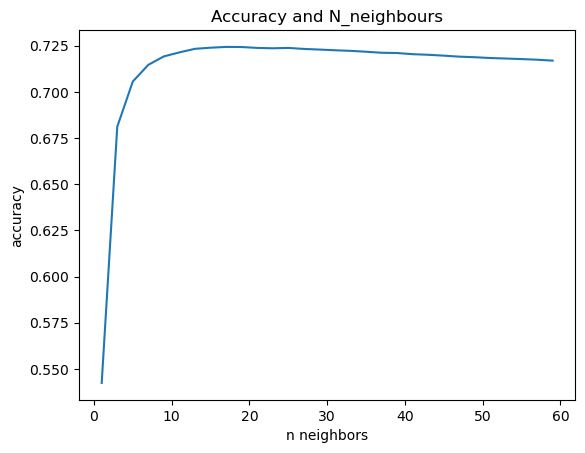

In [20]:
plt.figure()
plt.plot(k_values, cv_scores)
plt.title('Accuracy and N_neighbours')
#plt.scatter(x_points, y_points, alpha=0.5) # OPTIONAL
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.show()

In [21]:
which_max = np.array(cv_scores).argmax()
print("The best model has K = ",k_values[which_max])

The best model has K =  17


We have found that the optimal K value is 13. We shall input this into the KNN model as our parameters and fit the model and score this. We see that there is a Train score of 1.0 which is able to predict with very high accuracy. However against our test set we see a r-squared of 0.707 which means that the KNN model severly overfits on our train set and performs poorly onto the test set. 

In [25]:
KNNmodel = KNeighborsRegressor(n_neighbors=17,weights='distance')
KNNmodel.fit(X_remainder, y_remainder)

print(KNNmodel.score(X_remainder, y_remainder))
print(KNNmodel.score(X_test,y_test))


0.9999999990199652
0.7133892848861417


We then test the effects of running the same model on the data with respect to time. Or in otherwords only feeding our model information from the fiorst 80% of the data set to see if this can still predict homes within the last 20% of our data. 

In [26]:
KNNmodel = KNeighborsRegressor(n_neighbors=17,weights='distance')
KNNmodel.fit(X_remainder_date, y_remainder_date)

print(KNNmodel.score(X_remainder_date, y_remainder_date))
print(KNNmodel.score(X_test_date,y_test_date))


0.9999999989556804
0.6973515034202052


## Gradient Boosting <a class ='anchor' id = 'p1q3' ></a> 

We initiate our gradient boosting and test both splits that we have made(split by time and randomly split)

The first is the data that is split randomly using a regular train test split. 

In [15]:
from sklearn import ensemble
class StandardModel:
    
    model = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 20, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
#min_child_weight, eta add these parameters if we have time try n_estimators = 300,200,100, and Max depth = 15,10,5

In [ ]:
our_model = StandardModel()

GRB_fit = our_model.model.fit(X_remainder, y_remainder)

In [ ]:
print(f"R^2 score on training set: {GRB_fit.score(X_remainder, y_remainder)}")
print(f"R^2 score on test set: {GRB_fit.score(X_test, y_test)}")


We then instantiate the model which we will apply to the train and validation sets with respect to date or in other words the first 80% of the houses listed. 

In [ ]:
our_model_date = StandardModel()

GRB_fit_date = our_model_date.model.fit(X_remainder_date, y_remainder_date)



In [ ]:
print(f"R^2 score on training set: {GRB_fit_date.score(X_remainder_date, y_remainder_date)}")
print(f"R^2 score on test set: {GRB_fit_date.score(X_test_date, y_test_date)}")


With the two basic models run, we hyperparametize the model in regards to time. This will give us the best parameters

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA
    

In [ ]:

estimators = [
    ('model',ensemble.GradientBoostingRegressor())
]
pipe_GBR = Pipeline(estimators)

In [ ]:


# Three models, two scalers, two dimensional reducers
# Since each model has different parameter names, they each have to go in a separate dictionary. 


param_grid_GBR = [
    {
        'model': [ensemble.GradientBoostingRegressor()], 
        'model__n_estimators': [100,200,300,400],
        'model__max_depth':[5,10,15],
        'model__min_samples_split':[2,3]
    }
]

grid_GBR = GridSearchCV(pipe_GBR, param_grid_GBR, cv=tscv,verbose=20)

fittedgrid_GBR = grid_GBR.fit(X_remainder_date, y_remainder_date)




In [ ]:
fittedgrid_GBR.best_params_


In [16]:
from sklearn import ensemble
class StandardModel:
    
    model = ensemble.GradientBoostingRegressor(n_estimators = 300, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')


In [17]:
our_model_date2 = StandardModel()

GRB_fit_date2 = our_model_date2.model.fit(X_remainder_date, y_remainder_date)

In [18]:
print(f"R^2 score on training set: {GRB_fit_date2.score(X_remainder_date, y_remainder_date)}")
print(f"R^2 score on test set: {GRB_fit_date2.score(X_test_date, y_test_date)}")


R^2 score on training set: 0.9392525398725114
R^2 score on test set: 0.8679641926999443


In [20]:
filename = 'finalized_model.sav'
pickle.dump(GRB_fit_date2, open(filename, 'wb'))

In [26]:
# load the model from disk
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))





In [23]:
result = loaded_model.predict(X_test_date.iloc[[4000]])
print(result)

[2337088.77437424]


In [17]:
y_test_date.iloc[[4000]]

List Date
2021-08-30    2265000
Name: Price_num, dtype: int64

After hyper parametization with grid search, I was able to end with a high R-squared test score of 0.87 with a train score of 0.92 which shows relatively low overfitting. 

## XG Boosting <a class ='anchor' id = 'p1q4' ></a> 

After observing the past three models we run our last model. Once all models have run a basic model we will observe which has the highest test and train score as well as which has the least overfitting. So far the order is Gradient, KNN, then the linear regression. 

In [34]:
import xgboost as xg
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit


/Users/davidongtenco/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


First we work on the randomly split data to find out if we can properly predict home prices. We apply two trains of though to reduce over fitting. We apply a PCA to see if this will assist and we can observe our model bellow. 

In [ ]:
XGB = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 20, seed = 123)

XGB.fit(X_remainder, y_remainder)
print(XGB.score(X_remainder, y_remainder))
print(XGB.score(X_test,y_test))

In [ ]:
from sklearn.decomposition import PCA
x_pca= X_remainder
y_pca= y_remainder
X_test_pca = X_test
pca = PCA()

pca.fit(x_pca)
x_pca = pca.transform(x_pca)
X_test_pca = pca.transform(X_test_pca)


XGB = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 20, seed = 123)

XGB.fit(x_pca, y_pca)
print(XGB.score(x_pca, y_pca))
print(XGB.score(X_test_pca,y_test))

Next we model our data with the same model with the exact same parameters to find out 

In [ ]:
XGB = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 20, seed = 123)

XGB.fit(X_remainder_date, y_remainder_date)
print(XGB.score(X_remainder_date, y_remainder_date))
print(XGB.score(X_test_date,y_test_date))

In [ ]:
x_pca_date= X_remainder_date
y_pca_date= y_remainder_date
X_test_pca_date = X_test_date
pca = PCA()

pca.fit(x_pca_date)
x_pca = pca.transform(x_pca_date)
X_test_pca = pca.transform(X_test_pca_date)

XGB = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 20, seed = 123)

XGB.fit(x_pca_date, y_pca_date)
print(XGB.score(x_pca_date, y_pca_date))
print(XGB.score(X_test_pca_date,y_test))

Compared to our initial model in the 3rd notebook adding PCA failed to improve our model. Our next step will be to try a K-fold cross validation to increase our XG boost results. 

In [ ]:
# Define our list of k values to try out
k_values = list(range(20,61,10))

# Create a list to hold our cross-validation scores
cv_scores = []

for k in k_values:
    
    print(k)
    
    # Instantiate a knn classifier
    XGB = xg.XGBRegressor(objective ='reg:linear', n_estimators = k, seed = 123)
    
    # Calculate the 4 validation scores via cross-val & append average to list
    scores = cross_val_score(XGB, X_remainder, y_remainder, cv=4)
    
    cv_scores.append(np.mean(scores))
    

    # OPTIONAL: Keep track of x & y coordinates of every fold's validation score
    x_points.extend([k]*4)
    y_points.extend(scores)
    

plt.figure()
plt.plot(k_values, cv_scores)
# plt.scatter(x_points, y_points, alpha=0.5) # OPTIONAL
plt.xlabel('n neighbors')
plt.ylabel('R-sq')
plt.show()

In [ ]:

estimators = [
     #('dim_reducer', PCA()),
    ('model',xg.XGBRegressor())
]
pipe = Pipeline(estimators)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA

In [ ]:


# Three models, two scalers, two dimensional reducers
# Since each model has different parameter names, they each have to go in a separate dictionary. 


param_grid = [
    {
        'model': [xg.XGBRegressor()], 
        'model__n_estimators': [1,5,20,40,60],
        'model__min_child_weight': [3,6],
        'model__eta':[0.2,0.8],
        'model__max_depth':[3,11]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5,verbose=20)

fittedgrid = grid.fit(X_remainder, y_remainder)




In [ ]:
fittedgrid.best_params_



In [ ]:
XGB_update=xg.XGBRegressor(min_child_weight = 3, n_estimators=20)



In [ ]:
X_remainder_date = X_remainder_date.reset_index()
X_remainder_date


In [ ]:
X_remainder_date=X_remainder_date.drop(['List Date'],axis =1)

Using time series cross validation for the XG boosting 


In [ ]:




tscv = TimeSeriesSplit(max_train_size=None, n_splits =3)
for train_index, test_index in tscv.split(X_remainder_date): 
    print('TRAIN:', train_index, 'TEST:', test_index) 
    
    X_train_r, X_test_r =  X_remainder_date.loc[train_index,:], X_remainder_date.loc[test_index,:]
    print('X done')
    y_train_r, y_test_r = y_remainder_date[train_index], y_remainder_date[test_index]
    print('y done')







In [ ]:
# Define our list of k values to try out
k_values = list(range(0, 20,2))

# Create a list to hold our cross-validation scores
cv_scores = []


# OPTIONAL (if you want a scatterplot of individual fold validation scores)
# NOT TYPICALLY DONE
x_points = []
y_points = []



for k in k_values:
    
    print(k)
    
    # Instantiate a knn classifier
    XGB = xg.XGBRegressor(objective ='reg:linear', n_estimators = k, seed = 123)
    
    # Calculate the 4 validation scores via cross-val & append average to list
    scores = cross_val_score(XGB, X_remainder_date, y_remainder_date, cv=tscv)
    
    cv_scores.append(np.mean(scores))
    

    # OPTIONAL: Keep track of x & y coordinates of every fold's validation score
    x_points.extend([k]*4)
    y_points.extend(scores)
    

plt.figure()
plt.plot(k_values, cv_scores)
# plt.scatter(x_points, y_points, alpha=0.5) # OPTIONAL
plt.xlabel('n neighbors')
plt.ylabel('R-sq')
plt.show()

In [ ]:
# Find the index of best K
best_idx = np.argmax(cv_scores)
k_values[best_idx]

In [ ]:
XGB_date = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 500, seed = 123)

In [ ]:
x_pca_date= X_remainder_date
y_pca_date= y_remainder_date
X_test_pca = X_test_date
pca_date = PCA(n_components =0.9)

pca_date.fit(x_pca_date)
x_pca_date=pca.transform(x_pca_date)
X_test_pca=pca.transform(X_test_pca)
XGB_date.fit(x_pca_date, y_pca_date)
print(XGB_date.score(x_pca_date, y_pca_date))
print(XGB_date.score(X_test_pca,y_test_date))

In [ ]:
XGB_date.fit(X_remainder_date, y_remainder_date)
print(XGB_date.score(X_remainder_date, y_remainder_date))
print(XGB_date.score(X_test_date,y_test_date))

In [ ]:
param_grid_date = [
    {
        #'dim_reducer': [PCA(), KernelPCA()],
        'model': [xg.XGBRegressor()], 
        'model__n_estimators': [100, 300],
        #'model__min_child_weight': [3,6],
        'model__max_depth':[10,50]
    }
]

grid_date = GridSearchCV(pipe, param_grid_date, cv=tscv,verbose=20)

fittedgrid_date = grid_date.fit(X_remainder_date, y_remainder_date,verbose=20)




In [ ]:
fittedgrid_date.best_estimator_

In [ ]:
param_grid_date2 = [
    {
        #'dim_reducer': [PCA(), KernelPCA()],
        'model': [xg.XGBRegressor()], 
        'model__n_estimators': [300],
        #'model__min_child_weight': [3,6],
        'model__max_depth':[10,15,20]
    }
]

grid_date2 = GridSearchCV(pipe, param_grid_date2, cv=tscv,verbose=20)

fittedgrid_date2 = grid_date2.fit(X_remainder_date, y_remainder_date)

In [ ]:
fittedgrid_date2.best_estimator_

In [ ]:
param_grid_date3 = [
    {
        #'dim_reducer': [PCA(), KernelPCA()],
        'model': [xg.XGBRegressor()], 
        'model__n_estimators': [300,500],
        #'model__min_child_weight': [3,6],
        'model__max_depth':[5,10]
    }
]

grid_date3 = GridSearchCV(pipe, param_grid_date3, cv=tscv,verbose=20)

fittedgrid_date3 = grid_date3.fit(X_remainder_date, y_remainder_date)

In [ ]:
fittedgrid_date3.best_estimator_

We then apply our best parameters after using the grid search to find our hyoperparameters back into our model to test how it performs. 

In [35]:
XGB_best=xg.XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=10, min_child_weight=1,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None)

In [36]:
XGB_best.fit(X_remainder_date, y_remainder_date)
print(XGB_best.score(X_remainder_date, y_remainder_date))
print(XGB_best.score(X_test_date,y_test_date))




0.996886169695937
0.8599095896145994


In [ ]:
x_pca_date= X_remainder_date
y_pca_date= y_remainder_date
X_test_pca = X_test_date
pca_date = PCA(n_components = 0.80)

pca_date.fit(x_pca_date)
x_pca_date=pca_date.transform(x_pca_date)
X_test_pca=pca_date.transform(X_test_pca)

XGB_best=xg.XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=10, min_child_weight=1,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None)

XGB_best.fit(x_pca_date, y_pca_date)
print(XGB_best.score(x_pca_date, y_pca_date))
print(XGB_best.score(X_test_pca,y_test_date))



### Model Evaluation <a class ='anchor' id = 'p2q1' ></a> 
<a class ='anchor' id = 'part2' ></a> 

To summarize we have the following R-squared values for our four different models after completing K-fold Cross validation or Grid Searching to optimize and hyper parametize our models.  

| R-squared Values for 	| Train+Validation  	| Test  	| Difference |
|---	|---	|---	|---   |
|Linear Regression   	|0.7601028167376984   	|0.6918978346039175   	| 0.068|
|KNN Regressor   	|0.9999999990199652   	|0.7133892848861417   	| 0.286|
|Gradient Boosting   	|0.9392525398725114   	|0.8684749862386013   	| 0.071|
|XG Boosting   	|0.996886169695937|0.8599095896145994   	|0.136|

With these in mind, we can see that the model that has the highest test score as well as the least amount of overfitting is the Gradient Boosting model. From here forward we will complete further model evaluation on the Gradient Boosting model. 

As we are working with continous data, the model evaluation steps that would normally be available to discrete models such as accuracy, and recall would not be available. We work to acheive the highest R-sqared score or at least closest to 1 to find out that our model is performing and predict as well as possible. 

Further more to find out more about out model we want to find out what are we getting wrong in our predictions rather than what we are getting right. We want to answer the question, among the predictions that we are making incorrectly, are our predictions too small or too big? Are there trends in the types of homes that are failing to be predicted correctly. 

To find out the data that is being predicted incorrectly I will use a for loop to separate the rows that are failing. It will have similar structure as bellow. 
incorrect_prediction =[]

"for i in row: 
    GRB_fit_date2.predict(X_test_date) != to y_test_date
    incorrect_prediction.append(row(i))"
    

In theory this is what we would look for. However for the purposes of this notebook we will explore a different method as seen in stack overflow 
https://stackoverflow.com/questions/64693897/iterate-over-dataframe-within-condition-append-list

This method first creates a rule and using a tilde we are able to remove any rows that follow this rule. We set our rule to be where the Prediction value os equal to the actual sales price. Anything that followed this rule was removed. 

In [27]:
pred_value=loaded_model.predict(X_test_date)

In [30]:
pred_value

array([2508576.35388193,  607884.35953086,  658946.92949878, ...,
       1561063.91753947, 1515167.5028196 , 1583179.74741755])

In [28]:
df_test.head()

,Picture Count,DOM,Tot BR,Tot Baths,TotFlArea,Lot Sz (Sq.Ft.),Frontage - Feet,#Kitchens,Price_num,Prop_taxes,...,"('Williams Lake',)","('Williams Lake - City',)","('Williams Lake - Rural East',)","('Williams Lake - Rural North',)","('Williams Lake - Rural South',)","('Williams Lake - Rural West',)","('Willow River',)","('Wilson Creek',)","('Yale',)","('Yarrow',)"
List Date,,,,,,,,,,,,,,,,,,,,,
2021-06-29,40,111,5,5,3626,795400,66,2,2628000,729100,...,0,0,0,0,0,0,0,0,0,0
2021-06-29,18,10,5,3,2216,0,0,1,508000,417305,...,1,0,0,0,0,0,0,0,0,0
2021-06-29,21,2,5,2,2334,500000,50,2,484500,343362,...,0,0,0,0,0,0,0,0,0,0
2021-06-29,30,15,5,2,2124,0,0,1,412000,385217,...,0,0,0,0,0,0,0,0,0,0
2021-06-29,32,41,5,3,2670,0,0,1,530000,314008,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df2 = pd.DataFrame(pred_value,index=X_test_date.index)

In [32]:
df2.columns = ['Prediction Value']

In [33]:
comparison = pd.concat([df_test, df2],axis =1)

In [34]:
comparison['Price_num']

List Date
2021-06-29    2628000
2021-06-29     508000
2021-06-29     484500
2021-06-29     412000
2021-06-29     530000
               ...   
2022-10-24     810000
2022-10-24    1350000
2022-10-24    1500000
2022-10-24    1620000
2022-10-27    1515000
Name: Price_num, Length: 26299, dtype: int64

In [37]:
def is_within_errorbounds(actual,predicted):
    """ checks if predicted is within 14% above or bellow actual, and 
    returns false if it is
    """
    if predicted >= actual*1.14 or predicted <= actual*.86: 
        return False
    else: 
        return True 

In [40]:
comparison['is_within_errorbounds'] = comparison[['Price_num','Prediction Value']].apply(lambda x: is_within_errorbounds(x[0],x[1]),axis=1)

In [42]:
comparison[comparison['is_within_errorbounds'] == False]

,Picture Count,DOM,Tot BR,Tot Baths,TotFlArea,Lot Sz (Sq.Ft.),Frontage - Feet,#Kitchens,Price_num,Prop_taxes,...,"('Williams Lake - Rural East',)","('Williams Lake - Rural North',)","('Williams Lake - Rural South',)","('Williams Lake - Rural West',)","('Willow River',)","('Wilson Creek',)","('Yale',)","('Yarrow',)",Prediction Value,is_within_errorbounds
List Date,,,,,,,,,,,,,,,,,,,,,
2021-06-29,18,10,5,3,2216,0,0,1,508000,417305,...,0,0,0,0,0,0,0,0,6.078844e+05,False
2021-06-29,21,2,5,2,2334,500000,50,2,484500,343362,...,0,0,0,0,0,0,0,0,6.589469e+05,False
2021-06-29,23,132,3,2,1216,0,0,1,250000,91021,...,0,0,0,0,0,0,0,0,3.168573e+05,False
2021-06-29,16,56,3,1,1298,871200,0,1,170000,159990,...,0,0,0,0,0,0,0,0,2.663314e+05,False
2021-06-29,5,11,3,1,952,0,0,1,100000,60580,...,0,0,0,0,0,0,0,0,1.790660e+05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20,40,2,5,4,2540,570800,2747,2,1199999,529924,...,0,0,0,0,0,0,0,0,1.421414e+06,False
2022-10-21,18,1,4,2,2192,0,100,1,1350000,779786,...,0,0,0,0,0,0,0,0,2.353170e+06,False
2022-10-21,21,2,3,3,2250,439300,4995,1,1620000,243162,...,0,0,0,0,0,0,0,0,1.247717e+06,False


In [141]:
rows_to_delete = (
    (comparison['Price_num'] == comparison['Prediction Value']))

In [143]:
new_test=comparison[~rows_to_delete]

In [144]:
new_test[['Price_num','Prediction Value']]

,Price_num,Prediction Value
List Date,,
2021-06-29,2628000,2.508576e+06
2021-06-29,508000,6.078844e+05
2021-06-29,484500,6.589469e+05
2021-06-29,412000,4.529409e+05
2021-06-29,530000,4.641055e+05
...,...,...
2022-10-24,810000,1.167166e+06
2022-10-24,1350000,1.329503e+06
2022-10-24,1500000,1.561064e+06


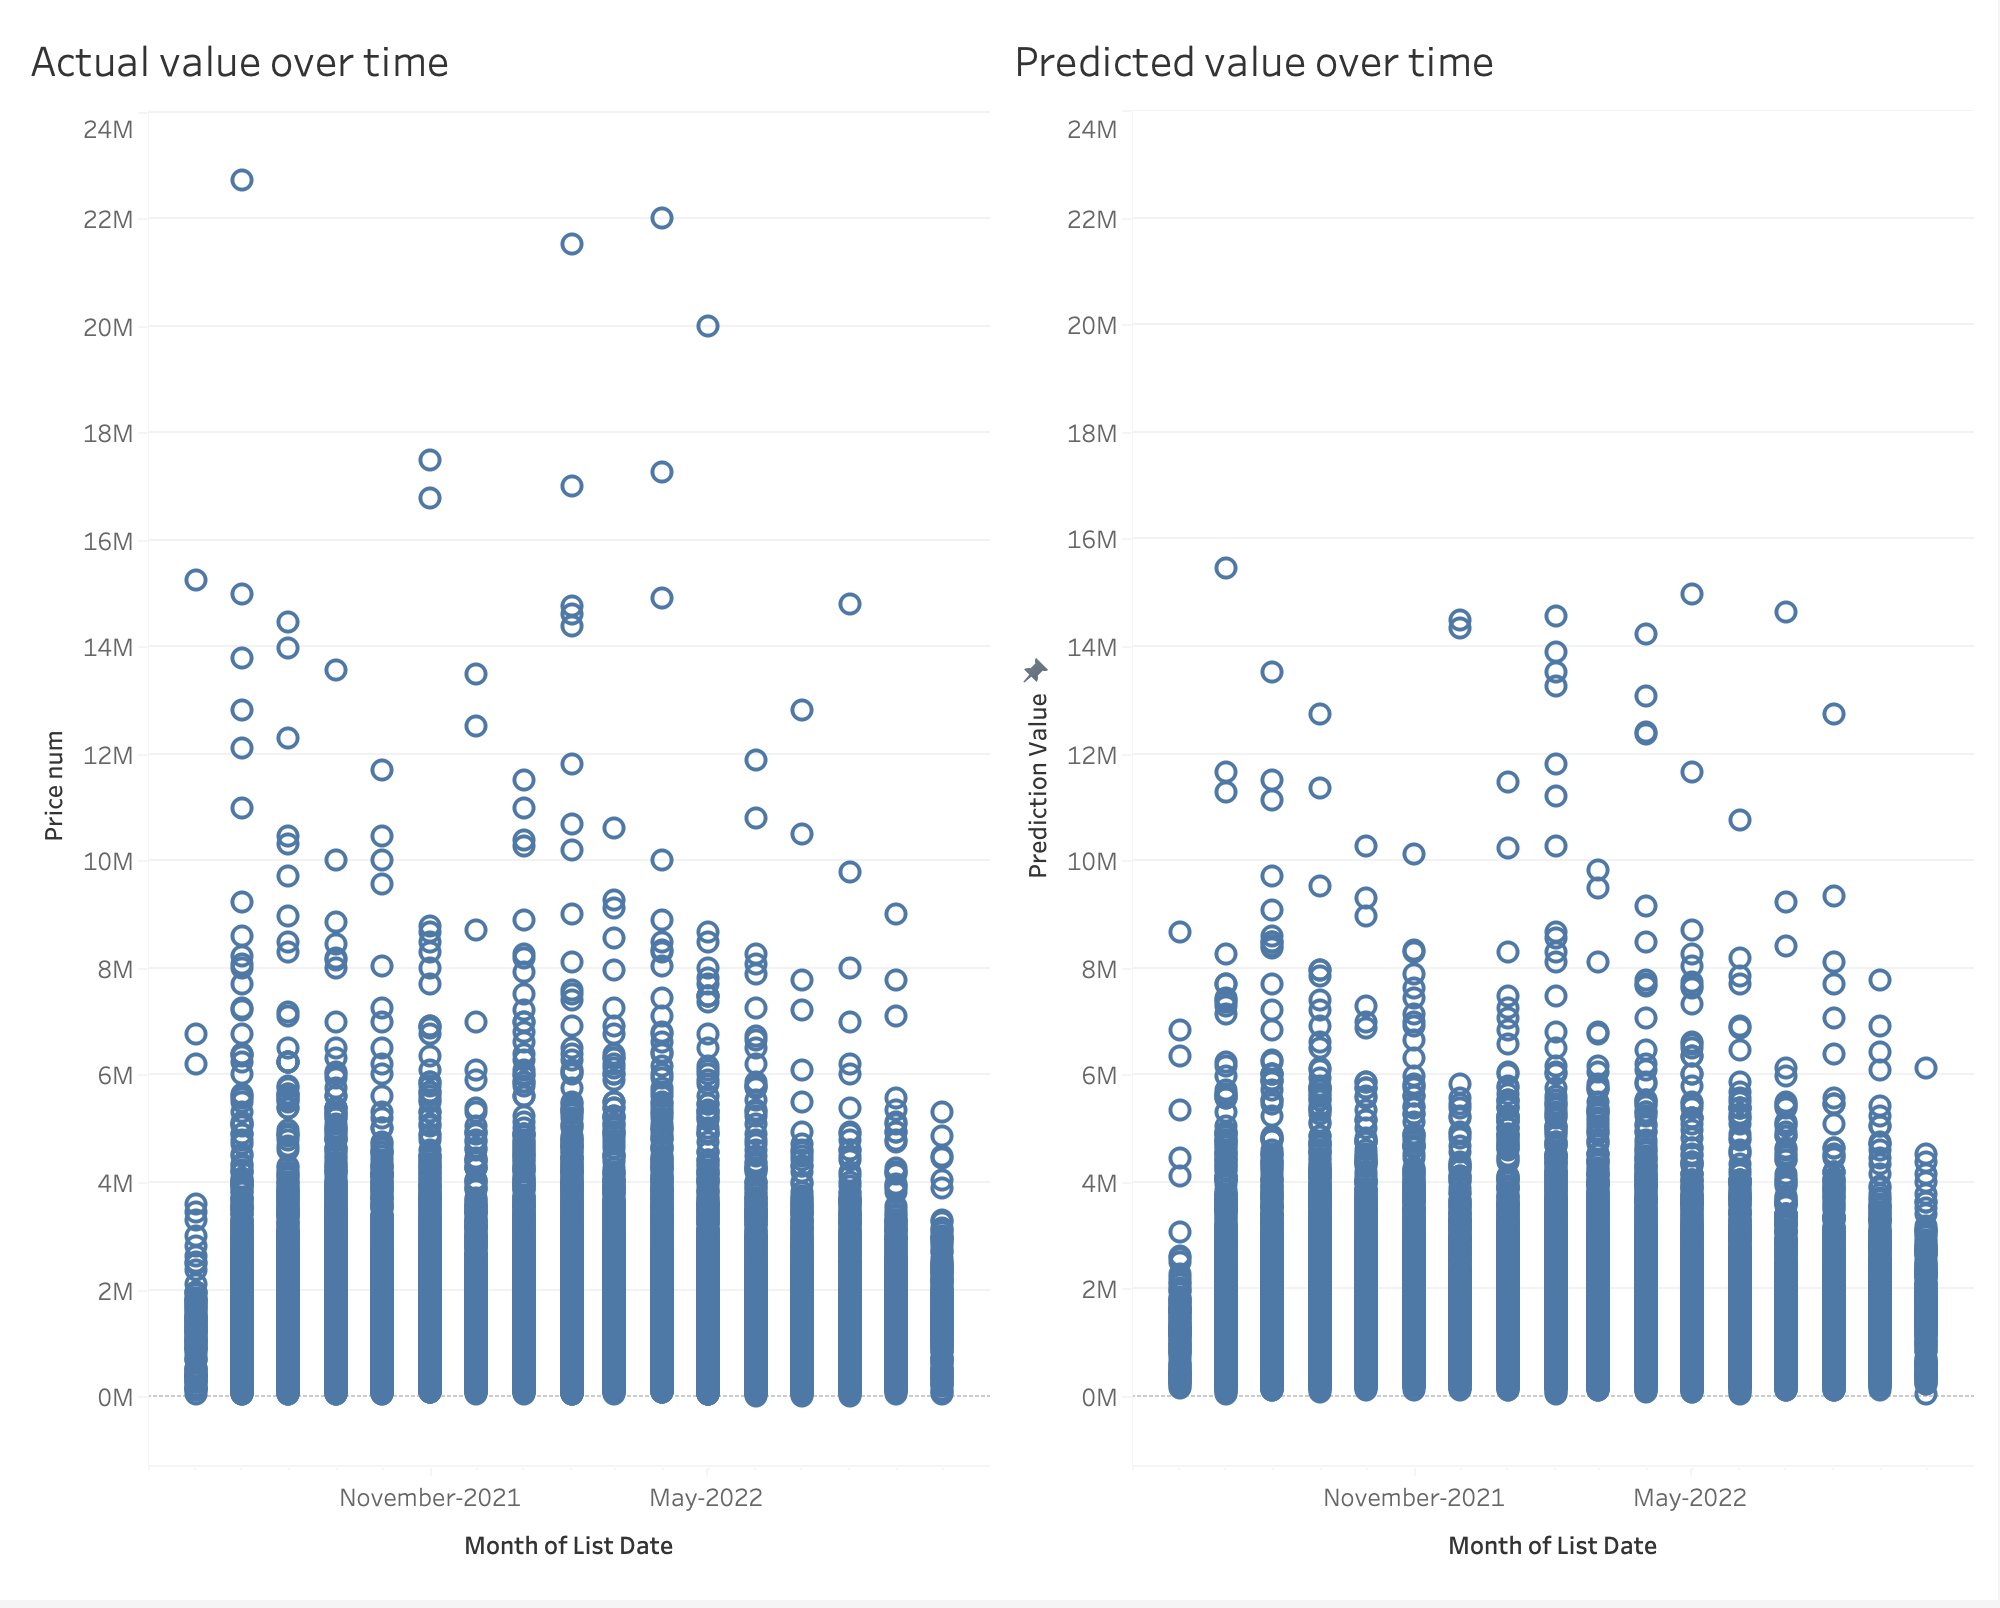

We see that there is a more of a spread in our data from the actual sales in comparison to the predicted values. Our model has reduced the variance on how these houses are predicted in comparison to the actual values. Although we attempoted to extract the transactions with the exact predicted and actual sales price we were unable to do so. What we can learn is that our model can get within 87% of the actual sales price of the home. 